In [1]:
import os
import json
import re
import math
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange

In [84]:
def radial_average(image, distance_transform, num_bins=100):
    """
    Compute the radial average of the image using the distance transform.
    
    Parameters:
    - image: 2D numpy array, the image from which to compute the radial average.
    - distance_transform: 2D numpy array, the distance from each pixel to the center.
    - num_bins: int, the number of radial bins.
    
    Returns:
    - bin_centers: 1D numpy array, the centers of the radial bins.
    - radial_avg: 1D numpy array, the average value in each radial bin.
    """
    # Flatten the arrays to make binning easier
    image_flat = image.flatten()
    distance_flat = distance_transform.flatten()
    
    # Define the radial bins
    radial_bins = np.linspace(0, np.max(distance_transform), num_bins + 1)
    bin_centers = (radial_bins[:-1] + radial_bins[1:]) / 2
    radial_avg = np.zeros(num_bins)
    counts = np.zeros(num_bins)  # to count valid pixels in each bin
    
    # Compute the average for each bin
    for i in range(num_bins):
        # Find indices where distances fall within the current bin
        indices = np.where((distance_flat >= radial_bins[i]) & (distance_flat < radial_bins[i + 1]))[0]
        
        if len(indices) > 0:
            radial_avg[i] = np.nanmean(image_flat[indices])
            counts[i] = len(indices)
        else:
            radial_avg[i] = np.nan
            counts[i] = 0
    
    # Handle cases where some bins have no valid pixels
    radial_avg[counts == 0] = np.nan
    
    return bin_centers,radial_avg

In [3]:
path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'

In [4]:
#scope_name = 'Ti scope'
scope_name = 'Ti scope'
path_scope = os.path.join(path_ext, scope_name)
exp_date = '2023_12_04'
df_date = '2023-12-04'
path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
pos = 19
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
vector = 'pLPT107&41'

In [5]:
fname = f'{exp_date}_10x_1.0x_{vector}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname_mask = 'mask_' + fname

In [6]:
path_im = os.path.join(path, fname)
path_masks = os.path.join(path, folder_masks, fname_mask)
path_results = os.path.join(path, folder_results, f"pos{pos}")

In [7]:
rfp_chn = 0
yfp_chn = 1
cfp_chn = 2
ph_chn = 3
fluo_chns = 3

In [8]:
im_all = imread(path_im).astype(float)
im_ph = im_all[:,:,:,ph_chn]
im_fluo = im_all[:,:,:,:ph_chn]

In [9]:
mask_all = imread(path_masks)
mask_all = mask_all / mask_all.max()

In [10]:
nt, nx, ny, nc = im_fluo.shape

#### Background substraction

In [38]:
# not working in radial averages
im = np.copy(im_fluo)
bg = im[0,0:100,0:100,:ph_chn].mean(axis=(1,2))
nt,nx,ny,nc = im.shape
for t in range(nt):
    #print(f'Smoothing frame {t+1}/{nt}')
    for c in range(nc):
        im[t,:,:,c] = im[t,:,:,c] - bg[c]

#### Mean fluo

In [12]:
mean_fluo = np.zeros((nc, nt))
for c in range(nc):
    for t in range(nt): 
        mask = mask_all[t]
        imtc = im[t,:,:,c]
        imtc[mask<=0] = np.nan
        mean_fluo[c,t] = np.nanmean(imtc)

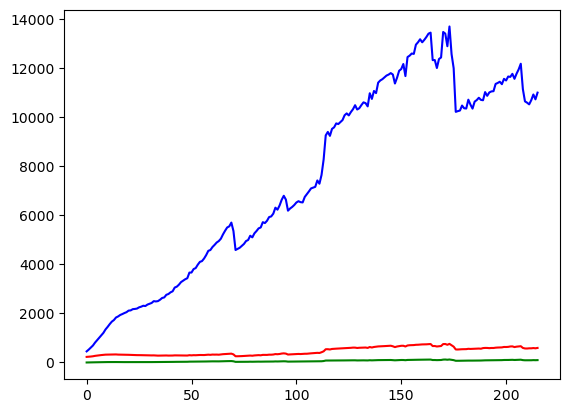

In [13]:
plt.plot(mean_fluo[0], 'r')
plt.plot(mean_fluo[1], 'g')
plt.plot(mean_fluo[2], 'b')
plt.show()

#### Radial averages

In [34]:
path_area = os.path.join(path_results, 'area.npy')
path_edt = os.path.join(path_results, 'edt.npy')
area = np.load(path_area)
edt = np.load(path_edt)

In [113]:
max_rad = np.sqrt(area[-1]/np.pi)
max_rad = np.math.ceil(max_rad)
max_rad

292

In [145]:
nbins = 100  # Number of radial bins
mean_fluo_rad = np.zeros((nc, nt, nbins))
im_fluo = im_all[:, :, :, :ph_chn]
for c in range(nc):
    for t in range(nt):
        # Select gene expression image for channel c and apply mask
        image = im_fluo[t, :, :, c]
        mask = mask_all[t]
        image[mask <= 0] = np.nan
        
        # Compute radial averages
        #rad = np.sqrt(area[t]/np.pi)
        #rad = np.math.ceil(max_rad)
        
        bin_centers, radial_avg = radial_average(image, edt[t,:,:], num_bins=nbins)
        #rad = np.sqrt(area[t]/np.pi)
        # Store radial averages (reverse time axis for kymograph plotting)
        #idx = np.where(bin_centers>rad)
        #radial_avg[idx] = np.nan
        #avgsl = len(radial_avg)
        mean_fluo_rad[c, t, :] = radial_avg
        #mean_fluo_rad[c, t, avgsl:] = np.nan

/tmp/ipykernel_1258976/4016043386.py:30: RuntimeWarning: Mean of empty slice
  radial_avg[i] = np.nanmean(image_flat[indices])


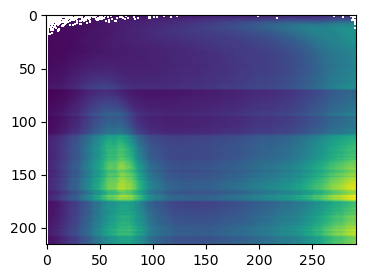

In [142]:
plt.figure(figsize=(4, 3))

# Plot the data
plt.imshow(mean_fluo_rad[0, :, :])
#plt.colorbar()
plt.show()

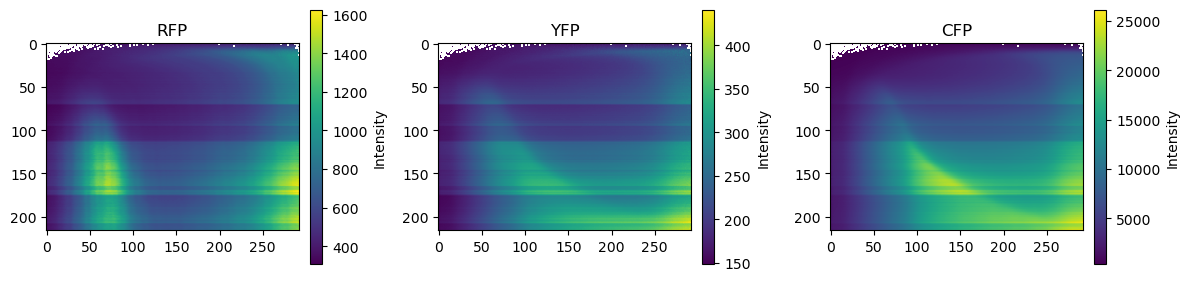

In [122]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot and customize each subplot
for i, ax in enumerate(axes):
    im = ax.imshow(mean_fluo_rad[i], cmap='viridis')  # Adjust the colormap as needed
    ax.set_title(['RFP', 'YFP', 'CFP'][i])  # Set appropriate title
    
    # Add colorbar next to each plot
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjust the position as needed
    cbar.set_label('Intensity')  # Set label for the colorbar

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [126]:
mean_fluo_rad[0, 50, :]

array([         nan, 342.70180437, 349.25336022, 350.7425876 ,
       352.40373396, 353.97826087, 354.53882834, 355.72127283,
       355.94915254, 357.46001797, 356.97099448, 357.8768679 ,
       359.45125348, 360.53142458, 360.75560224, 364.1824279 ,
       365.94985876, 367.95105422, 369.52865697, 373.71366995,
       376.10458453, 380.15086207, 382.73323508, 386.4192673 ,
       389.03637771, 391.2166302 , 393.50208044, 396.83945284,
       398.51147842, 399.94300518, 401.5619891 , 404.62420382,
       404.65473684, 408.19831224, 412.00644699, 412.95833333,
       417.24739195, 418.44523598, 425.57243319, 424.93435981,
       426.66721582, 429.47214485, 427.36392658, 428.72421875,
       429.70833333, 430.99848943, 430.43891403, 431.08095605,
       430.66454183, 432.96238245, 433.66718147, 436.18065068,
       436.34586466, 437.58909683, 438.96557121, 439.54701554,
       439.59863281, 438.00312744, 438.70336134, 437.31217839,
       435.08483896, 432.95504665, 433.67614679, 434.74

In [71]:
nt, nx, ny, nc = im_fluo.shape
# Initialize array to hold covariance matrices
#covariance_matrices = np.zeros((num_bins, 2, 2))
cov_rfp_yfp = np.zeros((nt,nbins))
corr_rfp_yfp = np.zeros((nt,nbins))
# Compute covariance matrix for each radial bin
for t in range(nt):
    #for r in range(nbins):
        # Select RFP and YFP data for current radial bin r
    rfp_data = mean_fluo_rad[0, t, :]
    yfp_data = mean_fluo_rad[1, t, :]
    
    # Compute covariance matrix for RFP and YFP
    covariance_matrix = np.cov(rfp_data, yfp_data)
    cov_rfp_yfp[t,:] = (rfp_data-rfp_data.mean())*(yfp_data-yfp_data.mean())*1/nbins
    corr_rfp_yfp[t,:] = cov_rfp_yfp[t,:] /(rfp_data.std()*yfp_data.std())
        # Store covariance matrix
        #covariance_matrices[r] = covariance_matrix
    
    # Now covariance_matrices contains the covariance matrix for each radial bin
    # covariance_matrices[r] is a 2x2 matrix where [0,0] is Var(RFP), [1,1] is Var(YFP), and [0,1] is Cov(RFP, YFP)

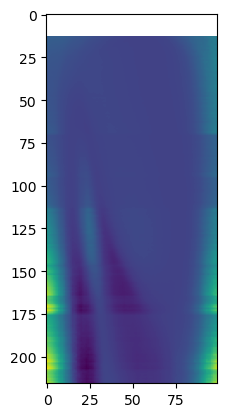

In [77]:
plt.imshow(cov_rfp_yfp)

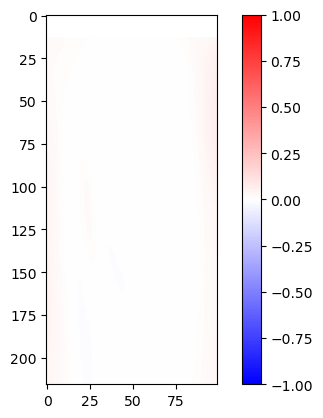

In [76]:
plt.imshow(corr_rfp_yfp, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

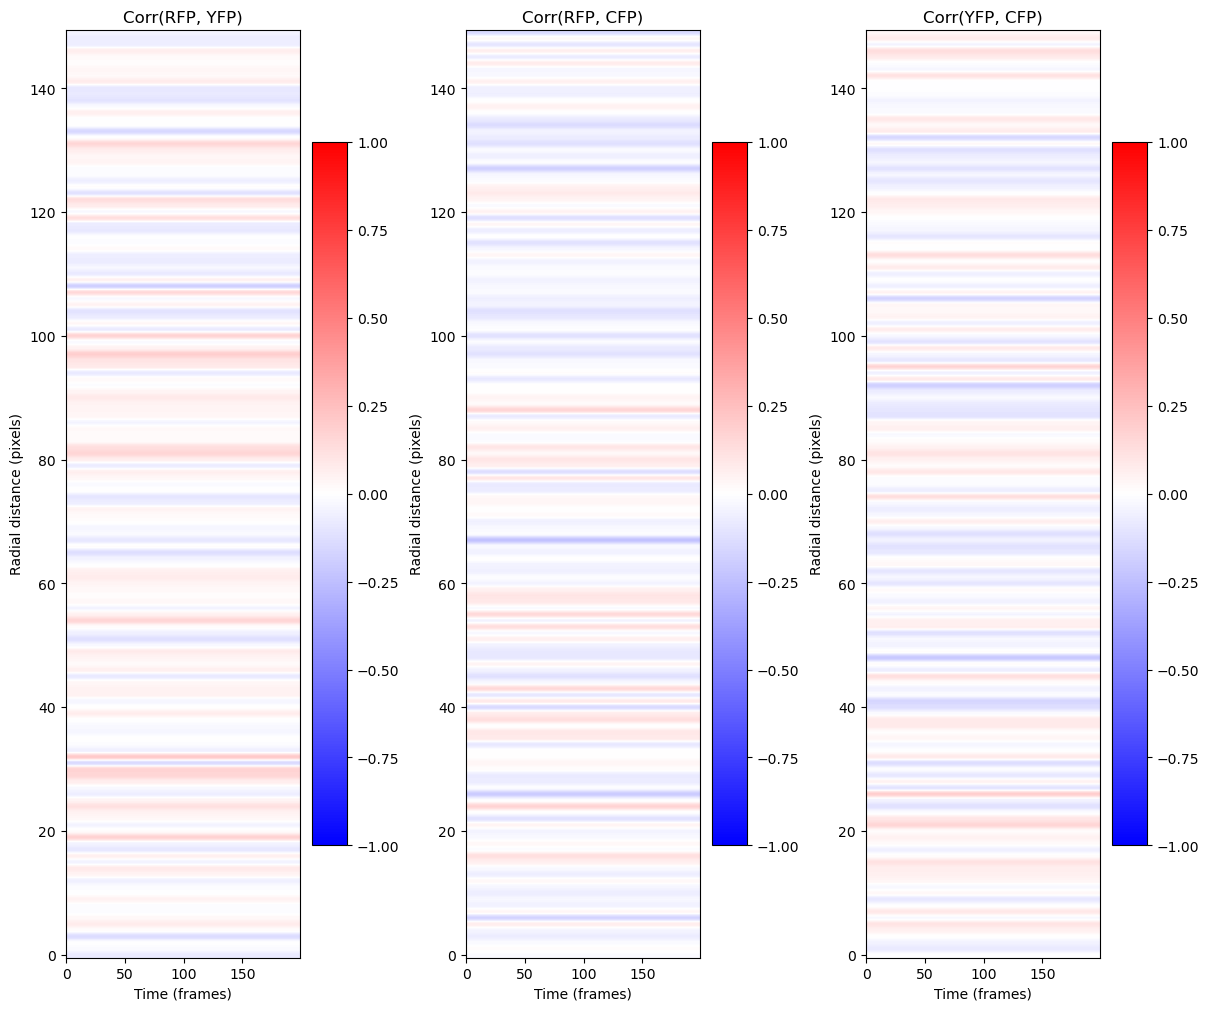

In [143]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate data for demonstration purposes
# Replace these with your actual data arrays for RFP, YFP, and CFP
nt, nr = 216, 100  # Number of time points, number of radial positions
rfp = np.random.rand(nt, nr)
yfp = np.random.rand(nt, nr)
cfp = np.random.rand(nt, nr)

# Compute correlation matrices for each pair of channels
corr_rfp_yfp = np.zeros((nt, nr))
corr_rfp_cfp = np.zeros((nt, nr))
corr_yfp_cfp = np.zeros((nt, nr))

for i in range(nr):
    corr_rfp_yfp[:, i] = [np.corrcoef(rfp[:, i], yfp[:, i])[0, 1] for t in range(nt)]
    corr_rfp_cfp[:, i] = [np.corrcoef(rfp[:, i], cfp[:, i])[0, 1] for t in range(nt)]
    corr_yfp_cfp[:, i] = [np.corrcoef(yfp[:, i], cfp[:, i])[0, 1] for t in range(nt)]

# Plotting the kymographs
fig, axes = plt.subplots(1, 3, figsize=(12, 10), constrained_layout=True)

im1 = axes[0].imshow(corr_rfp_yfp.T, cmap='bwr', aspect='auto', vmin=-1, vmax=1, origin='lower')
axes[0].set_title('Corr(RFP, YFP)')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Radial distance (pixels)')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(corr_rfp_cfp.T, cmap='bwr', aspect='auto', vmin=-1, vmax=1, origin='lower')
axes[1].set_title('Corr(RFP, CFP)')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Radial distance (pixels)')
fig.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(corr_yfp_cfp.T, cmap='bwr', aspect='auto', vmin=-1, vmax=1, origin='lower')
axes[2].set_title('Corr(YFP, CFP)')
axes[2].set_xlabel('Time (frames)')
axes[2].set_ylabel('Radial distance (pixels)')
fig.colorbar(im3, ax=axes[2])

plt.show()


#### Working radial averages

In [33]:
im_fluo = im_all[:, :, :, :ph_chn]
mean_fluo_rad = np.zeros((nc,nt,100))
for t in range(nt):
    for c in range(nc):
        edt_image = edt[t,:,:]
        
        # Assuming im_all and mask_all are your 4D image and mask arrays
        
        image = im_fluo[t, :, :, c]
        mask = mask_all[t]
        
        # Apply the mask: set masked areas to NaN
        image[mask <= 0] = np.nan
        
        # Compute the radial averages
        radial_avg = radial_average(image, edt_image)
    
        mean_fluo_rad[c,t,:] = radial_avg

/tmp/ipykernel_1258976/2346223501.py:30: RuntimeWarning: Mean of empty slice
  radial_avg[i] = np.nanmean(image_flat[indices])


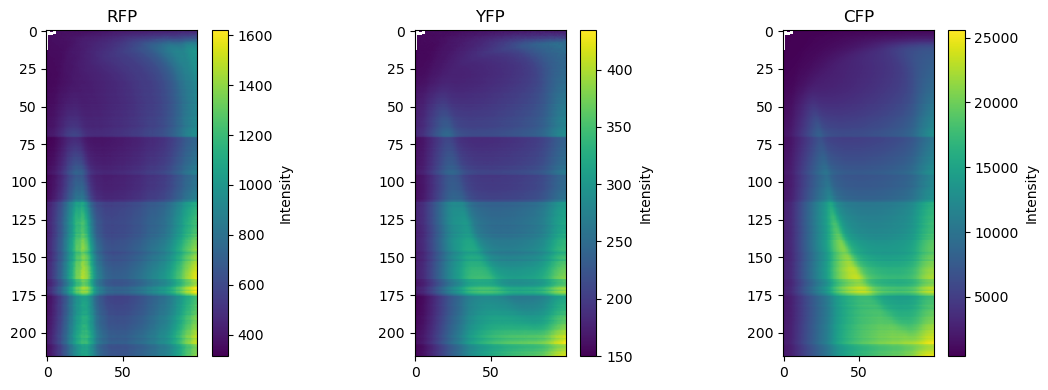

In [32]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot and customize each subplot
for i, ax in enumerate(axes):
    im = ax.imshow(mean_fluo_rad[i], cmap='viridis')  # Adjust the colormap as needed
    ax.set_title(['RFP', 'YFP', 'CFP'][i])  # Set appropriate title
    
    # Add colorbar next to each plot
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjust the position as needed
    cbar.set_label('Intensity')  # Set label for the colorbar

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()